#### Applied Machine Learning - Deep Learning Project 1 (Tasnim Ahmed, ta1743)

# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple

import torch
import torch.nn as nn

from torch.jit.annotations import Optional, Tuple
from torch import Tensor

import os
import os.path
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
from ipywidgets import IntProgress

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

In [3]:
print(device)

cuda


-----
## Configuration
### Hyper Parameters
We then set up and hyper parameters that need for the our model.
We need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. number of epoches
5. out put directory

In [4]:
lr = 0.001                 
trainBatchSize = 20        
testBatchSize = 20        
epochs = 60               
output_file = "./output"    

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [5]:
if not os.path.exists(output_file):
    os.makedirs(output_file)    

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary libraries for data loading

In [6]:
import torchvision.datasets as dset 
import torch.utils.data as data       

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testing set. Note that the testing split do not require any transform

In [7]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [8]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paper below to understand the structure.
### https://arxiv.org/abs/1409.4842



------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [9]:
# in_planes   - inout to all the blocks
# kernal_1_x  - output from the 1x1
# kernal_3_in - input for the 3x3
# kernal_3_x  - output from the 3x3
# kernal_5_x  - input for the 5x5
# kernal_5_x  - output from the 5x5
# pool_planes - pooling planes

class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()

#what about the kernel size?

        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size = 1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 5, padding = 2), 
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True)
        )
         
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_planes, pool_planes, kernel_size = 1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True)
        )
        
        
    def forward(self, x):
        b1 = self.b1(x)
        b2 = self.b2(x)
        b3 = self.b3(x)
        b4 = self.b4(x)
        concat = torch.cat([b1, b2, b3, b4], 1)
        return concat

-----
### GoogLeNet Module (There exist many implement methods)


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convolution with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    2. Two Inception blocks
    
    3. Maxpooling layer
    
    4. Five Inception blocks
    
    5. Maxpooling layer
    
    6. Two Inception blocks  
    
    7. Average Pooling layer
    
    8. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [10]:
class GoogLeNet(nn.Module):
    def __init__(self):   
        super(GoogLeNet, self).__init__()
        
        # First convolution block
        self.a_block = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 192, kernel_size = 3, padding = 1), 
            nn.BatchNorm2d(192), 
            nn.ReLU(True)
        )
        
        # Two Inception Blocks
        self.inceptionBlock1 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inceptionBlock2 = Inception(256, 128, 128, 192, 32, 96, 64)
    
        # Maxpooling Layer
        self.maxPool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # Five Inception Blocks
        self.inceptionBlock3 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inceptionBlock4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inceptionBlock5 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inceptionBlock6 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inceptionBlock7 = Inception(528, 256, 160, 320, 32, 128, 128)
    
        # Maxpooling Layer
        self.maxPool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # Two Inception Blocks
        self.inceptionBlock8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inceptionBlock9 = Inception(832, 384, 192, 384, 48, 128, 128)
    
        # Average Pooling
        self.averagePool = nn.AvgPool2d(kernel_size = 8, stride = 1)  
        
        # Fully Connected Layer
        #self.dropout = nn.Dropout(p = ?)
        self.fullyConnected = nn.Linear(1024,10)
        
    
    def forward(self,input_x):
        x = self.a_block(input_x)
        
        x = self.inceptionBlock1(x)
        x = self.inceptionBlock2(x)
        
        x = self.maxPool1(x)
        
        x = self.inceptionBlock3(x)
        x = self.inceptionBlock4(x)
        x = self.inceptionBlock5(x)
        x = self.inceptionBlock6(x)
        x = self.inceptionBlock7(x)
        
        x = self.maxPool2(x)
        
        x = self.inceptionBlock8(x)
        x = self.inceptionBlock9(x)
        
        x = self.averagePool(x)
        
        x = x.reshape(x.shape[0], -1)
        
        x = self.fullyConnected(x)
        
        return x     

### Next, we create the networka and send it to the target device

In [11]:
googleNet = GoogLeNet()       
googleNet.to(device)

GoogLeNet(
  (a_block): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inceptionBlock1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, ep

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [12]:
optimizer = torch.optim.Adam(googleNet.parameters(), lr = lr) 
criterion = nn.CrossEntropyLoss()
milestone = [50,100]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestone, gamma = 0.5) 

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [13]:
training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []

for epoch in range(epochs):
    
    # 1. STEP THE SCHEDULER 
    if epoch != 0:
        scheduler.step()
    
    # 2. T R A I N I N G
    train_correct_preds = 0
    train_cummulative_loss = .0
    train_data_size = 0
    
    for data, label in train_loader:
        
        # Put the data to correct device
        data = data.to(device)
        label = label.to(device)

        # Reset the gradient of optimizer
        optimizer.zero_grad()
        
        # Feed the data forward to the google net
        ffwd = googleNet(data)
        
        # Use the criterion function to compute the loss term 
        loss = criterion(ffwd, label)
        
        # Backpropagate the loss
        loss.backward()
        
        # Update the network parameters with the optimizer
        optimizer.step()
        
        # Accumulate the training loss
        train_cummulative_loss += loss.item()
        
        # Find the prediction
        _, train_predicted = torch.max(ffwd.data, 1)
        
        # Increment the data size and the correct prediction
        train_data_size += label.size(0)
        train_correct_preds += (train_predicted == label).sum().item()
        
    # Appending to training history arrays
    train_cummulative_loss /= len(train_loader)
    training_loss.append(train_cummulative_loss)
        
    train_run_acc = train_correct_preds/train_data_size
    training_accuracy.append(train_run_acc)
        
    # Print the log
    print("Epoch: ", epoch)
    print('Training | Accuracy: {:.3f}%'.format(100 * train_run_acc ), end=' | ')
    print('Loss: {:.5f}'.format(train_cummulative_loss))
    

    # 3. T E S T I N G
    
    with torch.no_grad():      # the gradient doesn't change based on the testing data
        
        test_correct_preds = 0
        test_cummulative_loss = .0
        test_data_size = 0
        
        
        for data_t, label_t in test_loader:
            
            # Put the data to the correct devices 
            data_t = data_t.to(device)
            label_t = label_t.to(device)
            
            
            # Feed the data forward to googleNet
            ffwd_test = googleNet(data_t)
            
            # Use the criterion function to compute the loss
            loss_t = criterion(ffwd_test, label_t)
            
            # Accumulate the testing loss
            test_cummulative_loss += loss_t.item()
            
            # Find the prediction
            _, test_predicted = torch.max(ffwd_test.data, 1)
            
            # Increment the data size and the number of correct predictions
            test_data_size += label_t.size(0)
            test_correct_preds += (test_predicted == label_t).sum().item()
            
        # Append to testing history array
        test_cummulative_loss /= len(test_loader)
        testing_loss.append(test_cummulative_loss)
        
        test_run_acc = test_correct_preds/test_data_size
        testing_accuracy.append(test_run_acc)    
            
        # Print the log
        print('Testing | Accuracy: {:.3f}%'.format(100 * test_run_acc ), end=' | ')
        print('Loss: {:.5f}'.format(test_cummulative_loss))
        print()
    
    
    # 4. Save the module then print the accuracy
    torch.save(googleNet.state_dict(), output_file+"/module.pt")

Epoch:  0
Training | Accuracy: 51.096% | Loss: 1.34083
Testing | Accuracy: 66.440% | Loss: 0.94343

Epoch:  1
Training | Accuracy: 70.892% | Loss: 0.83691
Testing | Accuracy: 73.760% | Loss: 0.74868

Epoch:  2
Training | Accuracy: 77.408% | Loss: 0.65628
Testing | Accuracy: 78.040% | Loss: 0.63289

Epoch:  3
Training | Accuracy: 81.096% | Loss: 0.54587
Testing | Accuracy: 80.550% | Loss: 0.56054

Epoch:  4
Training | Accuracy: 83.670% | Loss: 0.47089
Testing | Accuracy: 83.370% | Loss: 0.48978

Epoch:  5
Training | Accuracy: 86.020% | Loss: 0.40660
Testing | Accuracy: 84.110% | Loss: 0.46102

Epoch:  6
Training | Accuracy: 87.344% | Loss: 0.36421
Testing | Accuracy: 85.200% | Loss: 0.44131

Epoch:  7
Training | Accuracy: 89.038% | Loss: 0.31805
Testing | Accuracy: 85.800% | Loss: 0.42225

Epoch:  8
Training | Accuracy: 90.256% | Loss: 0.28036
Testing | Accuracy: 87.050% | Loss: 0.38740

Epoch:  9
Training | Accuracy: 91.112% | Loss: 0.25174
Testing | Accuracy: 87.810% | Loss: 0.37759



## Report

In [14]:
import matplotlib.pyplot as plt

### Loss

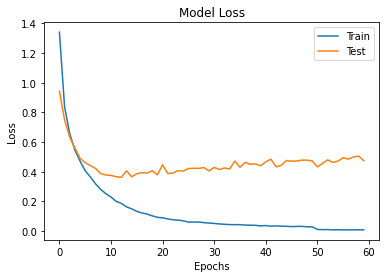

In [15]:
plt.plot(training_loss, label='Train')
plt.plot(testing_loss, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Model Loss')
plt.legend()
plt.show()

### Accuracy

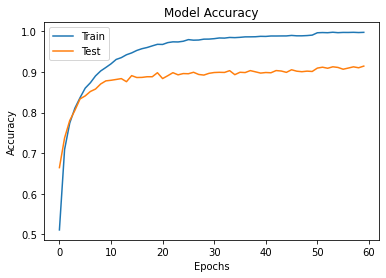

In [16]:
plt.plot(training_accuracy, label='Train')
plt.plot(testing_accuracy, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Model Accuracy')
plt.legend()
plt.show()